# ml04_philip.ipynb
 - Machine Learning with the Titanic Dataset
 - Philip Fowler
 - 1 April 2025
 - This notebook is a simple example of machine learning using the Titanic dataset.
 - The goal is to predict whether a passenger survived the Titanic disaster based on their attributes.
 - The dataset is available from the Seaborn library.

In [ ]:
# install libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, mean_squared_error, mean_absolute_error, r2_score, precision_score, recall_score, f1_score
from sklearn.tree import DecisionTreeClassifier, plot_tree, DecisionTreeRegressor
from sklearn.svm import SVC, SVR
from sklearn.neural_network import MLPClassifier
from pandas.plotting import scatter_matrix

sns.set_style('whitegrid')
dont_panic = 42



## Section 1. Load and Explore the Data

### 1.1 Load the dataset and display the first 10 rows

In [193]:
# Load Titanic dataset
titanic = sns.load_dataset('titanic')

titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.7+ KB


what is the difference in pclass vs class?  Can we drop class?
what is the difference between sex and who?  Can we drop who?
Why a separate column for adult male?
Do we ned to keep emarked town?
Is alive the same as survived?
How is alone useful?

survived is the target variable 1=survived, 0=died
pclass is the ticket class 1=1st, 2=2nd, 3=3rd
name, sex, age seem straightforward!
sibsp is the number of siblings/spouses aboard
parch is the number of parents/children aboard
ticket is the ticket number
fare is the passenger fare
cabin is the cabin number
embarked is the port of embarkation C=Cherbourg, Q=Queenstown, S=Southampton

In [194]:
titanic.head(10)

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True
5,0,3,male,NaN,0,0,8.4583,Q,Third,man,True,NaN,Queenstown,no,True
6,0,1,male,54.0,0,0,51.8625,S,First,man,True,E,Southampton,no,True
7,0,3,male,2.0,3,1,21.0750,S,Third,child,False,NaN,Southampton,no,False
8,1,3,female,27.0,0,2,11.1333,S,Third,woman,False,NaN,Southampton,yes,False
9,1,2,female,14.0,1,0,30.0708,C,Second,child,False,NaN,Cherbourg,yes,False


### 1.2 Check for missing values and display summary statistics


In [195]:
titanic.isnull().sum()

survived         0
pclass           0
sex              0
age            177
sibsp            0
parch            0
fare             0
embarked         2
class            0
who              0
adult_male       0
deck           688
embark_town      2
alive            0
alone            0
dtype: int64

In [196]:
titanic['embarked'] = titanic['embarked'].fillna(titanic['embarked'].mode()[0])
titanic['age'] = titanic.groupby(['pclass', 'sex'])['age'].transform(lambda x: x.fillna(x.median()))

## Section 2. Visualize Feature Distributions


In [197]:
titanic.describe().T

,count,mean,std,min,25%,50%,75%,max
survived,891.0,0.383838,0.486592,0.00,0.0000,0.0000,1.0,1.0000
pclass,891.0,2.308642,0.836071,1.00,2.0000,3.0000,3.0,3.0000
age,891.0,29.112424,13.304424,0.42,21.5000,26.0000,36.0,80.0000
sibsp,891.0,0.523008,1.102743,0.00,0.0000,0.0000,1.0,8.0000
parch,891.0,0.381594,0.806057,0.00,0.0000,0.0000,0.0,6.0000
fare,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292


In [198]:
titanic.corr(numeric_only=True)

,survived,pclass,age,sibsp,parch,fare,adult_male,alone
survived,1.000000,-0.338481,-0.059579,-0.035322,0.081629,0.257307,-0.557080,-0.203367
pclass,-0.338481,1.000000,-0.413583,0.083081,0.018443,-0.549500,0.094035,0.135207
age,-0.059579,-0.413583,1.000000,-0.249854,-0.175526,0.122692,0.263411,0.175529
sibsp,-0.035322,0.083081,-0.249854,1.000000,0.414838,0.159651,-0.253586,-0.584471
parch,0.081629,0.018443,-0.175526,0.414838,1.000000,0.216225,-0.349943,-0.583398
fare,0.257307,-0.549500,0.122692,0.159651,0.216225,1.000000,-0.182024,-0.271832
adult_male,-0.557080,0.094035,0.263411,-0.253586,-0.349943,-0.182024,1.000000,0.404744
alone,-0.203367,0.135207,0.175529,-0.584471,-0.583398,-0.271832,0.404744,1.000000


The above correlations were done to determine a better way to fill in the missing values for age.  It seems to me that 1st class passengers are likely older than third class passengers.  Thus, perhaps we should fill the missing values for age using the median based on passenger class.

### 2.1 Create histograms, boxplots, and scatterplots


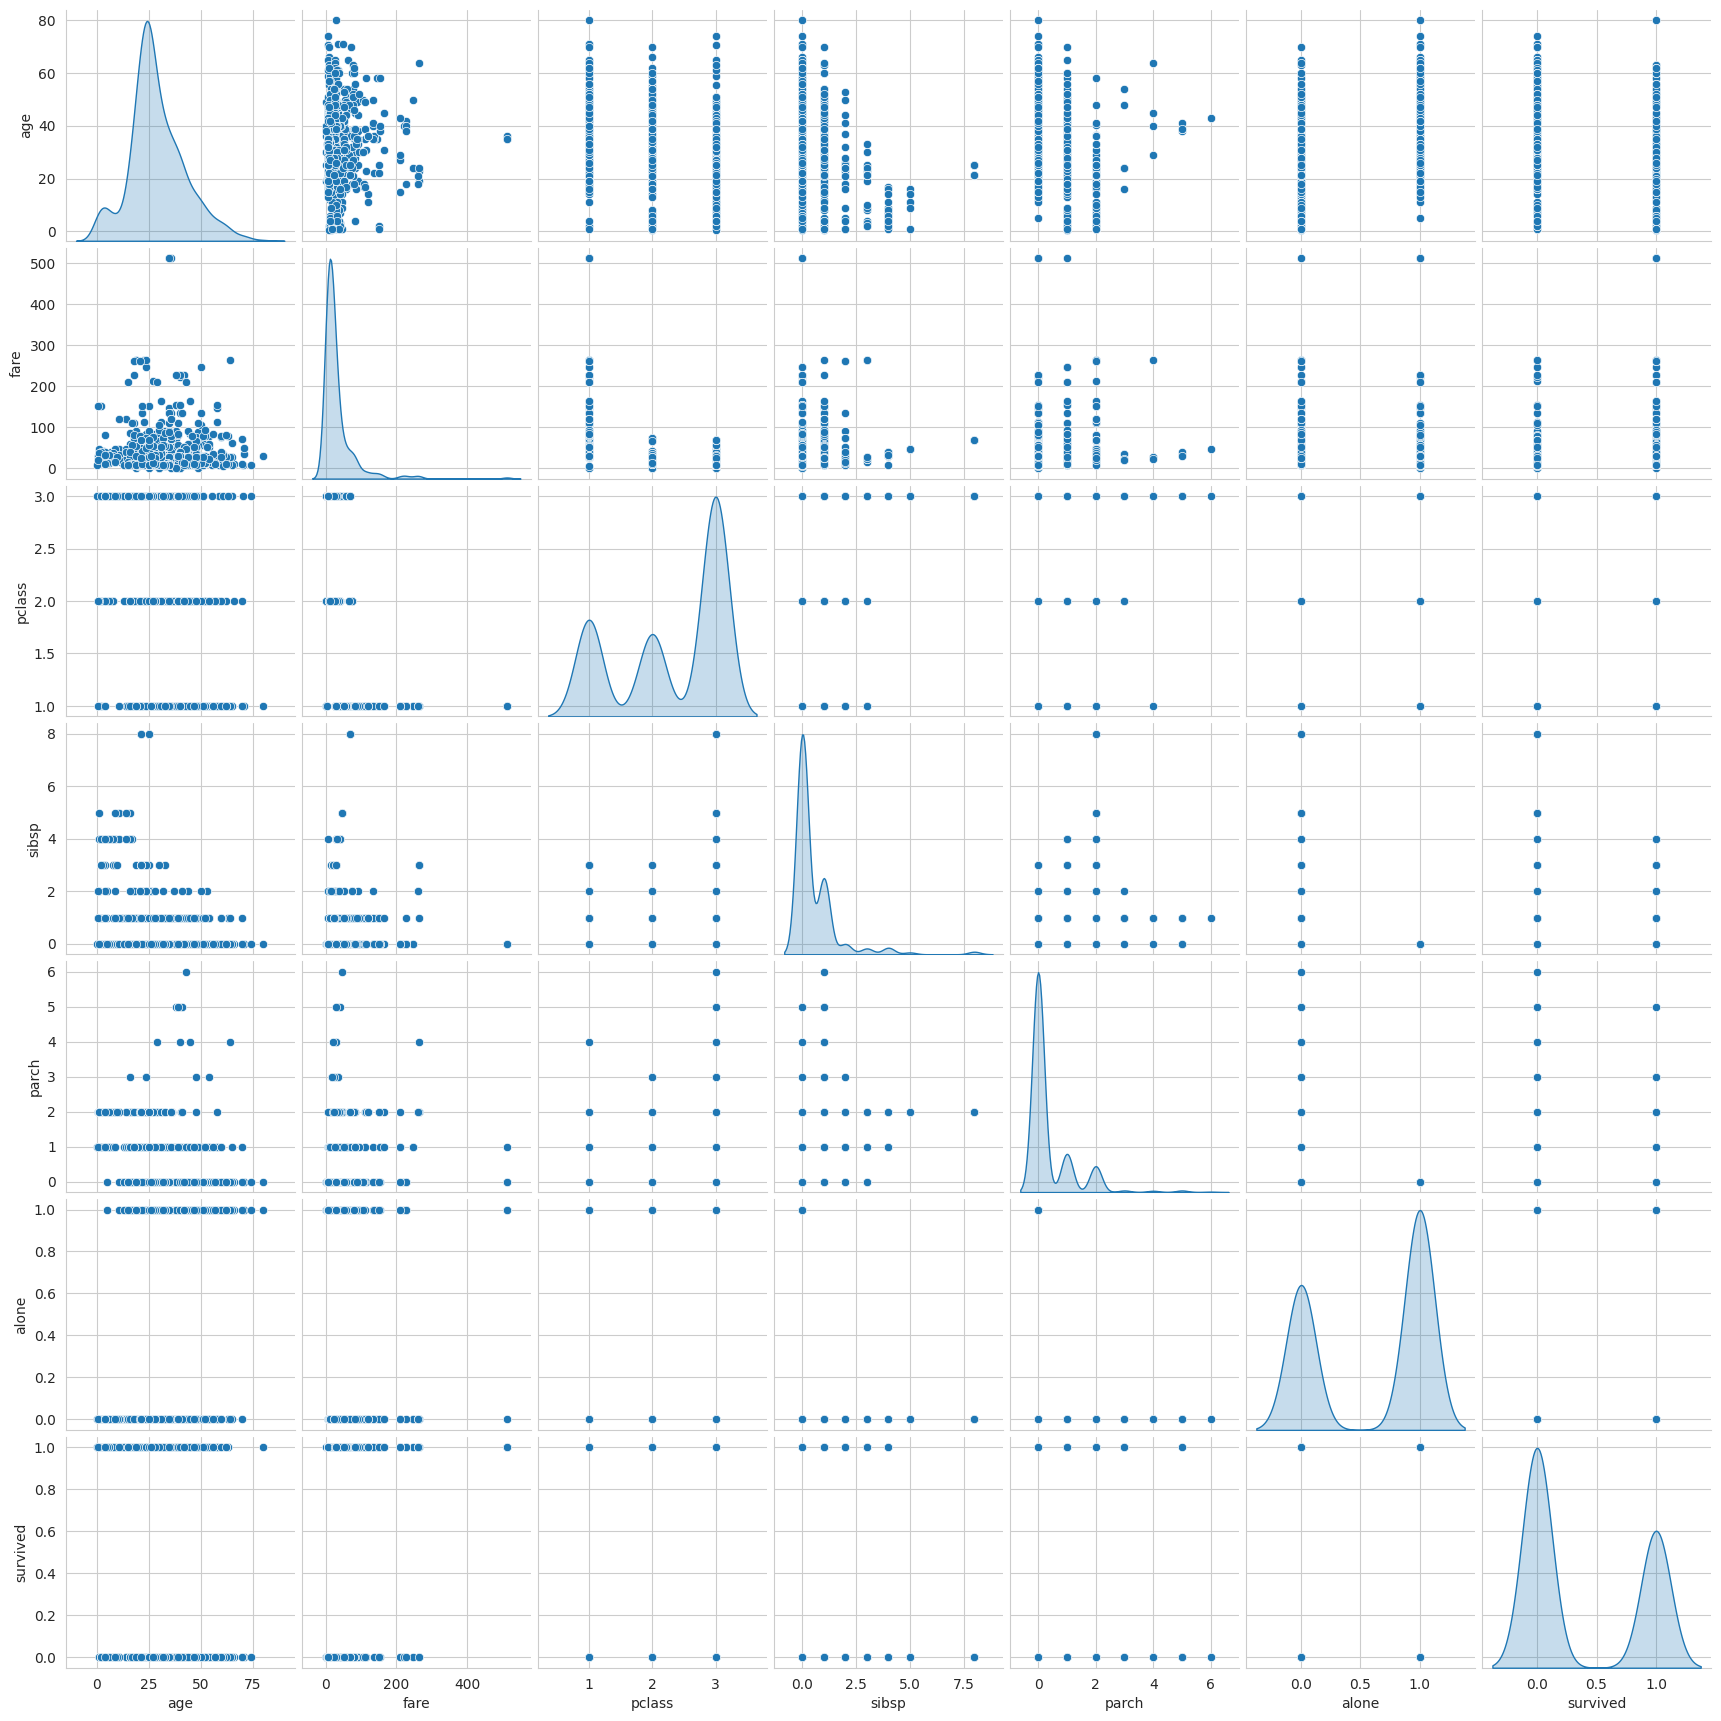

In [199]:
attributes = ['age', 'fare', 'pclass', 'sex', 'sibsp', 'parch', 'alone', 'survived']
sns.pairplot(titanic[attributes], diag_kind='kde')
plt.show()

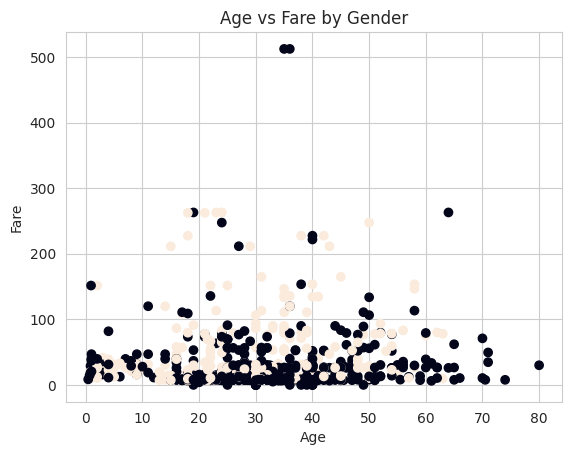

In [200]:
plt.scatter(titanic['age'], titanic['fare'], c=titanic['sex'].apply(lambda x: 0 if x == 'male' else 1))
plt.xlabel('Age')
plt.ylabel('Fare')
plt.title('Age vs Fare by Gender')
plt.show()

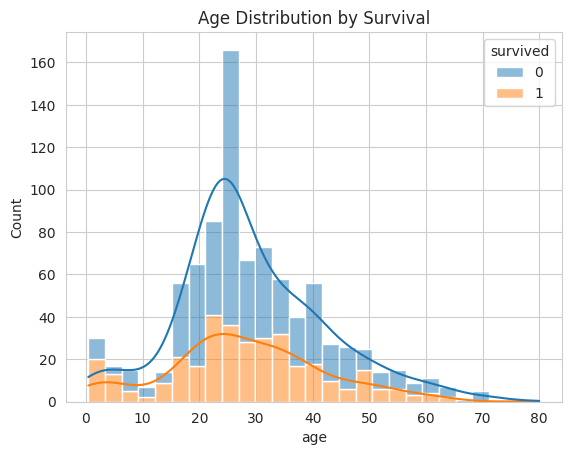

In [201]:
sns.histplot(data=titanic, x='age', hue='survived', kde=True, multiple='stack')
plt.title('Age Distribution by Survival')
plt.show()

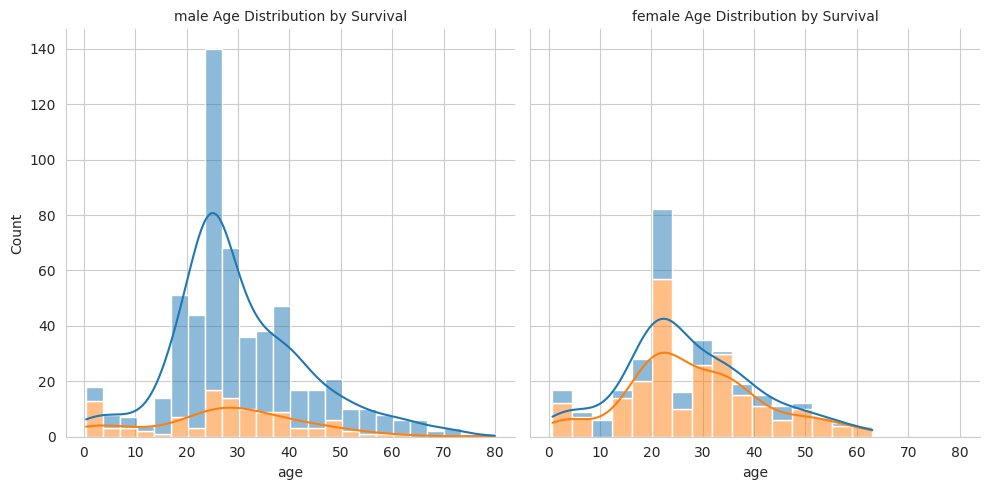

In [202]:
g = sns.FacetGrid(titanic, col="sex", height=5, aspect=1)
g.map(sns.histplot, "age", hue="survived", data=titanic, kde=True, multiple="stack")
g.set_titles("{col_name} Age Distribution by Survival")
plt.show()

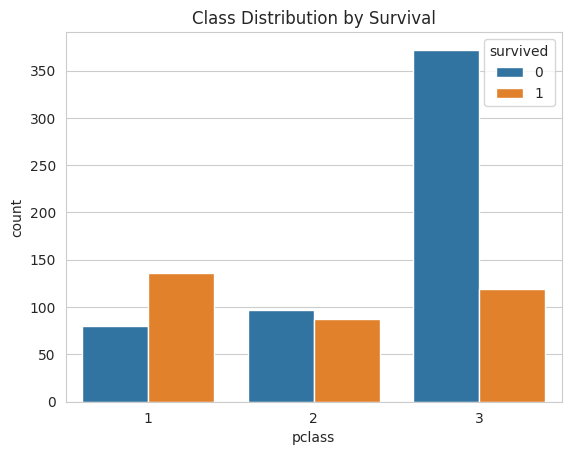

In [203]:
sns.countplot(x='pclass', hue='survived', data=titanic)
plt.title('Class Distribution by Survival')
plt.show()

### 2.2 Feature Engineering

In [204]:
titanic['age'] = titanic['age'].fillna(titanic['age'].median())

# why are we using embarked town when we have embarked column?
titanic['embark_town'] = titanic['embark_town'].fillna(titanic['embark_town'].mode()[0])


In [205]:
titanic['family_size'] = titanic['sibsp'] + titanic['parch'] + 1

titanic['sex'] = titanic['sex'].map({'male': 0, 'female': 1})
titanic['embarked'] = titanic['embarked'].map({'C': 0, 'Q': 1, 'S': 2})

titanic['alone'] = titanic['alone'].astype(int)


## Section 3. Feature Selection and Justification
### 3.1 Choose input features for predicting the target

In [236]:
# Define the cases
cases = {
    'Case 1: alone only': titanic[['alone']],
    'Case 2: age only': titanic[['age']],
    'Case 3: family_size only': titanic[['family_size']],    
    'Case 4: age + family_size': titanic[['age', 'family_size']],
    'Case 5: pclass + embarked': titanic[['pclass', 'embarked']],
    'Case 6: age + pclass + sex + family_size': titanic[['age', 'pclass', 'sex', 'family_size']],

}

# Target variable
y = titanic['fare']

# Iterate through each case and run the models
results = {}

for case_name, X in cases.items():
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    #  Linear Regression
    linear_model = LinearRegression()
    linear_model.fit(X_train, y_train)
    y_pred_linear = linear_model.predict(X_test)
    linear_train_score = linear_model.score(X_train, y_train)
    mse_linear = mean_squared_error(y_test, y_pred_linear)
    r2_linear = r2_score(y_test, y_pred_linear)
    rmse_linear = np.sqrt(mse_linear)

    # Decision Tree  Regressor
    tree_model = DecisionTreeRegressor()
    tree_model.fit(X_train, y_train)
    y_pred_tree = tree_model.predict(X_test)
    mse_tree = mean_squared_error(y_test, y_pred_tree)
    r2_tree = r2_score(y_test, y_pred_tree)
    rmse_tree = np.sqrt(mse_tree)

    # SVR
    svm_model_rbf = SVR(kernel='rbf')
    svm_model_rbf.fit(X_train, y_train)
    y_pred_svm_rbf = svm_model_rbf.predict(X_test)
    mse_svm_rbf = mean_squared_error(y_test, y_pred_svm_rbf)
    r2_svm_rbf = r2_score(y_test, y_pred_svm_rbf)
    rmse_svm_rbf = np.sqrt(mse_svm_rbf)

    # Ridge Regression
    ridge_model = Ridge(alpha=1.0)
    ridge_model.fit(X_train, y_train)
    y_pred_ridge = ridge_model.predict(X_test)
    mse_ridge = mean_squared_error(y_test, y_pred_ridge)
    r2_ridge = r2_score(y_test, y_pred_ridge)
    rmse_ridge = np.sqrt(mse_ridge)

    # Lasso Regression
    lasso_model = Lasso(alpha=0.3)
    lasso_model.fit(X_train, y_train)
    y_pred_lasso = lasso_model.predict(X_test)
    mse_lasso = mean_squared_error(y_test, y_pred_lasso)
    r2_lasso = r2_score(y_test, y_pred_lasso)
    rmse_lasso = np.sqrt(mse_lasso)

    # ElasticNet Regression
    elasticnet_model = ElasticNet(alpha=0.3, l1_ratio=0.5)  
    elasticnet_model.fit(X_train, y_train)
    y_pred_elasticnet = elasticnet_model.predict(X_test)
    mse_elasticnet = mean_squared_error(y_test, y_pred_elasticnet)
    r2_elasticnet = r2_score(y_test, y_pred_elasticnet)
    rmse_elasticnet = np.sqrt(mse_elasticnet)

    # Polynomial Regression
    poly_features = PolynomialFeatures(degree=3) 
    X_poly_train = poly_features.fit_transform(X_train)  
    X_poly_test = poly_features.transform(X_test) 
    poly_model = LinearRegression()  
    poly_model.fit(X_poly_train, y_train) 
    y_pred_poly = poly_model.predict(X_poly_test) 
    mse_poly = mean_squared_error(y_test, y_pred_poly)  
    r2_poly = r2_score(y_test, y_pred_poly)  
    rmse_poly = np.sqrt(mse_poly)  

    # Polynomial Regression
    poly5_features = PolynomialFeatures(degree=5) 
    X_poly5_train = poly_features.fit_transform(X_train)  
    X_poly5_test = poly_features.transform(X_test) 
    poly5_model = LinearRegression()  
    poly5_model.fit(X_poly_train, y_train) 
    y_pred_poly5 = poly_model.predict(X_poly_test) 
    mse_poly5 = mean_squared_error(y_test, y_pred_poly)  
    r2_poly5 = r2_score(y_test, y_pred_poly)  
    rmse_poly5 = np.sqrt(mse_poly)  

    # Store results
    results[case_name] = {
        'Linear Regression': {
            'Linear Train Score': linear_train_score,
            'MSE': mse_linear,
            'R2': r2_linear,
            'RMSE': rmse_linear
        },
        'Decision Tree Regression': {
            'MSE': mse_tree,
            'R2': r2_tree,
            'RMSE': rmse_tree
        },
        'SVR (RBF Kernel)': {
            'MSE': mse_svm_rbf,
            'R2': r2_svm_rbf,
            'RMSE': rmse_svm_rbf
        },
        'Ridge Regression': {
            'MSE': mse_ridge,
            'R2': r2_ridge,
            'RMSE': rmse_ridge
        },
        'Lasso Regression': {
            'MSE': mse_lasso,
            'R2': r2_lasso,
            'RMSE': rmse_lasso
        },
        'ElasticNet Regression': {
            'MSE': mse_elasticnet,
            'R2': r2_elasticnet,
            'RMSE': rmse_elasticnet
        },
        'Polynomial Regression Cubic': {
            'MSE': mse_poly,
            'R2': r2_poly,
            'RMSE': rmse_poly
        },
        'Polynomial Regression degree=5': {
            'MSE': mse_poly5,
            'R2': r2_poly5,
            'RMSE': rmse_poly5
        }
    }

# Print results
for case_name, case_results in results.items():
    print(f"Results for {case_name}:")
    for model_name, metrics in case_results.items():
        print(f"  {model_name}:")
        for metric_name, value in metrics.items():
            print(f"    {metric_name}: {value}")
    print()

Results for Case 1: alone only:
  Linear Regression:
    Linear Train Score: 0.0663649118980516
    MSE: 1355.7884711112572
    R2: 0.12384482364401006
    RMSE: 36.82103299897027
  Decision Tree Regression:
    MSE: 1355.7884711112572
    R2: 0.12384482364401006
    RMSE: 36.82103299897027
  SVR (RBF Kernel):
    MSE: 1610.2272414077183
    R2: -0.04058189218296304
    RMSE: 40.127636877938855
  Ridge Regression:
    MSE: 1355.8901433864414
    R2: 0.12377911967020239
    RMSE: 36.822413600773665
  Lasso Regression:
    MSE: 1356.9152707347935
    R2: 0.12311664860497307
    RMSE: 36.83633085331373
  ElasticNet Regression:
    MSE: 1390.8385163294724
    R2: 0.10119432970355025
    RMSE: 37.293947449009366
  Polynomial Regression Cubic:
    MSE: 1355.7884711112567
    R2: 0.12384482364401028
    RMSE: 36.82103299897026
  Polynomial Regression degree=5:
    MSE: 1355.7884711112567
    R2: 0.12384482364401028
    RMSE: 36.82103299897026

Results for Case 2: age only:
  Linear Regression

In [246]:
# Create a list to store the linear regression results
linear_results = []

# Iterate through the results dictionary and extract the required information for Linear Regression only
for case_name, case_results in results.items():
    features_used = cases[case_name].columns.tolist()
    if 'Linear Regression' in case_results:
        metrics = case_results['Linear Regression']
        linear_results.append({
            'Case': case_name,
            'Features Used': ', '.join(features_used),
            'Training R2': metrics.get('Linear Train Score', None),
            'MSE': metrics['MSE'],
            'R2': metrics['R2'],
            'RMSE': metrics['RMSE']
        })

# Convert the results list to a DataFrame
linear_results_df = pd.DataFrame(linear_results)

linear_results_df.head(6)


,Case,Features Used,Training R2,MSE,R2,RMSE
0,Case 1: alone only,alone,0.066365,1355.788471,0.123845,36.821033
1,Case 2: age only,age,0.011895,1495.055002,0.033846,38.665941
2,Case 3: family_size only,family_size,0.044743,1451.914298,0.061725,38.103993
3,Case 4: age + family_size,"age, family_size",0.074659,1352.499223,0.125970,36.776341
4,Case 5: pclass + embarked,"pclass, embarked",0.317917,1046.844435,0.323495,32.354975
5,Case 6: age + pclass + sex + family_size,"age, pclass, sex, family_size",0.366006,928.212982,0.400158,30.466588


| Model Type | Case | Features Used | Accuracy | Precision | Recall | F1-Score | Notes |
|------------|------|---------------|----------|-----------|--------|-----------|-------|
| **Decision Tree** | Case 1 | alone | xx.xx% | xx.xx% | xx.xx% | xx.xx% | - |
|                   | Case 2 | age | xx.xx% | xx.xx% | xx.xx% | xx.xx% | - |
|                   | Case 3 | age + family_size | xx.xx% | xx.xx% | xx.xx% | xx.xx% | - |
|-------------------|------|---------------|----------|-----------|--------|-----------|-------|
| **SVM (RBF Kernel)** | Case 1 | alone | xx.xx% | xx.xx% | xx.xx% | xx.xx% | - |
|                    | Case 2 | age | xx.xx% | xx.xx% | xx.xx% | xx.xx% | - |
|                    | Case 3 | age + family_size | xx.xx% | xx.xx% | xx.xx% | xx.xx% | - |
|-------------------|------|---------------|----------|-----------|--------|-----------|-------|
| **SVM (Linear Kernel)** | Case 1 | alone | xx.xx% | xx.xx% | xx.xx% | xx.xx% | - |
|                    | Case 2 | age | xx.xx% | xx.xx% | xx.xx% | xx.xx% | - |
|                    | Case 3 | age + family_size | xx.xx% | xx.xx% | xx.xx% | xx.xx% | - |
|-------------------|------|---------------|----------|-----------|--------|-----------|-------|
| **SVM (Poly Kernel)** | Case 1 | alone | xx.xx% | xx.xx% | xx.xx% | xx.xx% | - |
|                    | Case 2 | age | xx.xx% | xx.xx% | xx.xx% | xx.xx% | - |
|                    | Case 3 | age + family_size | xx.xx% | xx.xx% | xx.xx% | xx.xx% | - |
|-------------------|------|---------------|----------|-----------|--------|-----------|-------|
| **SVM (Sigmoid Kernel)** | Case 1 | alone | xx.xx% | xx.xx% | xx.xx% | xx.xx% | - |
|                    | Case 2 | age | xx.xx% | xx.xx% | xx.xx% | xx.xx% | - |
|                    | Case 3 | age + family_size | xx.xx% | xx.xx% | xx.xx% | xx.xx% | - |
|-------------------|------|---------------|----------|-----------|--------|-----------|-------|
| **Neural Network (MLP)** | Case 1 | alone | xx.xx% | xx.xx% | xx.xx% | xx.xx% | - |
|                    | Case 2 | age | xx.xx% | xx.xx% | xx.xx% | xx.xx% | - |
|                    | Case 3 | age + family_size | xx.xx% | xx.xx% | xx.xx% | xx.xx% | - |

In [247]:
# Create a list to store the results
results_list = []

# Iterate through the results dictionary and extract the required information
for case_name, case_results in results.items():
    features_used = cases[case_name].columns.tolist()
    for model_name, metrics in case_results.items():
        results_list.append({
            'Model': model_name,
            'Case': case_name,
            'Features Used': ', '.join(features_used),
            'MSE': metrics['MSE'],
            'R2': metrics['R2'],
            'RMSE': metrics['RMSE']
        })

# Create a DataFrame from the results list
results_df = pd.DataFrame(results_list)


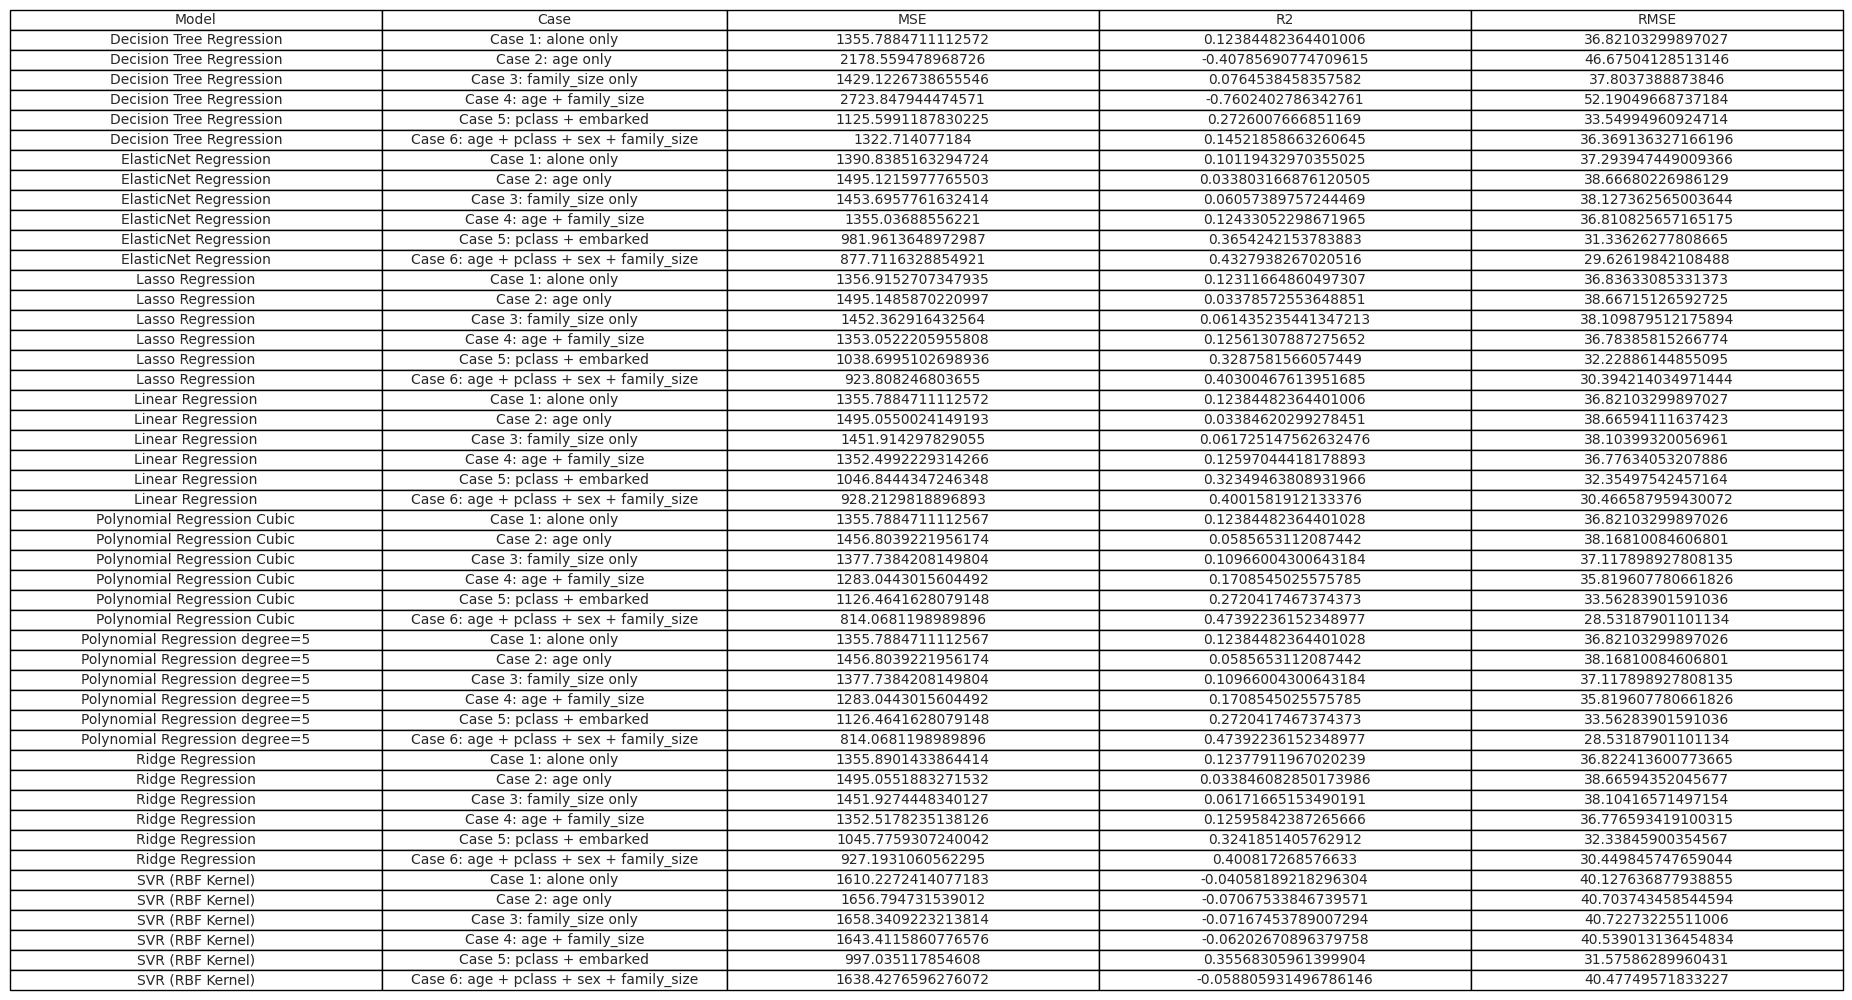

In [248]:
# Sort the DataFrame by 'Model' and then by 'Case'
sorted_results_df = results_df.sort_values(by=['Model', 'Case'])

# Extract the data from the sorted results DataFrame
table_data = sorted_results_df[['Model', 'Case', 'MSE', 'R2', 'RMSE']].values

# Format the values as percentages limited to two decimal places
# table_data = [[f'{value:.2%}' if isinstance(value, float) else value for value in row] for row in table_data]

# Create a figure and axis
fig, ax = plt.subplots(figsize=(20, 8))

# Hide the axes
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_frame_on(False)

# Create the table
table = ax.table(cellText=table_data, colLabels=['Model', 'Case', 'MSE', 'R2', 'RMSE'], cellLoc='center', loc='center')

# Adjust the table properties
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)

# Adjust column widths
table.auto_set_column_width([1])  # Set the width of the 'Case' column

# Display the table
plt.show()

# Save the table as an image
fig.savefig('results_table.png', dpi=300, bbox_inches='tight')

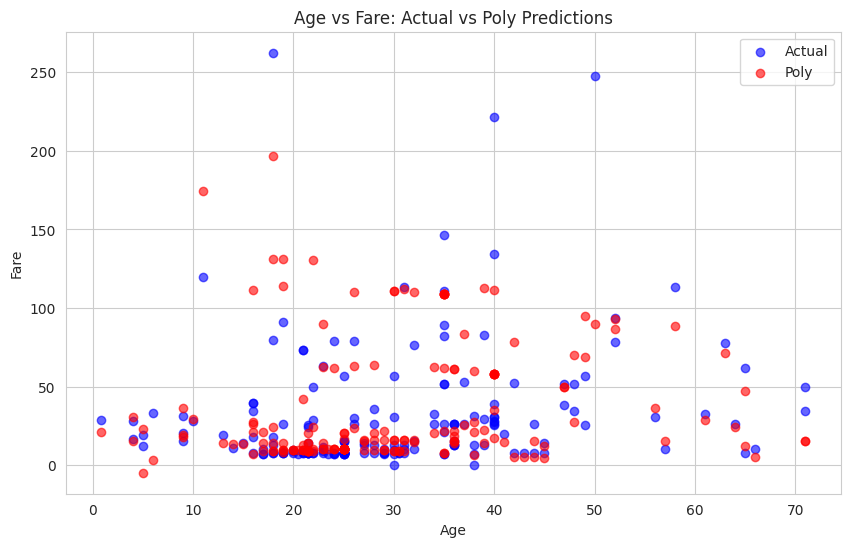

In [249]:
plt.figure(figsize=(10, 6))

# Extract the 'age' column from X_test if it exists
if isinstance(X_test, pd.DataFrame) and 'age' in X_test.columns:
    age_test = X_test['age']
else:
    raise ValueError("The 'age' column is not present in X_test.")

# Ensure age_test and y_test have the same size
if len(age_test) != len(y_test):
    raise ValueError("Mismatch in size between age_test and y_test.")

# Scatterplot for actual values
plt.scatter(age_test, y_test, color='blue', label='Actual', alpha=0.6)

# Scatterplot for predicted values (poly)
plt.scatter(age_test, y_pred_poly, color='red', label='Poly', alpha=0.6)

# Add labels, title, and legend
plt.xlabel('Age')
plt.ylabel('Fare')
plt.title('Age vs Fare: Actual vs Poly Predictions')
plt.legend()
plt.show()

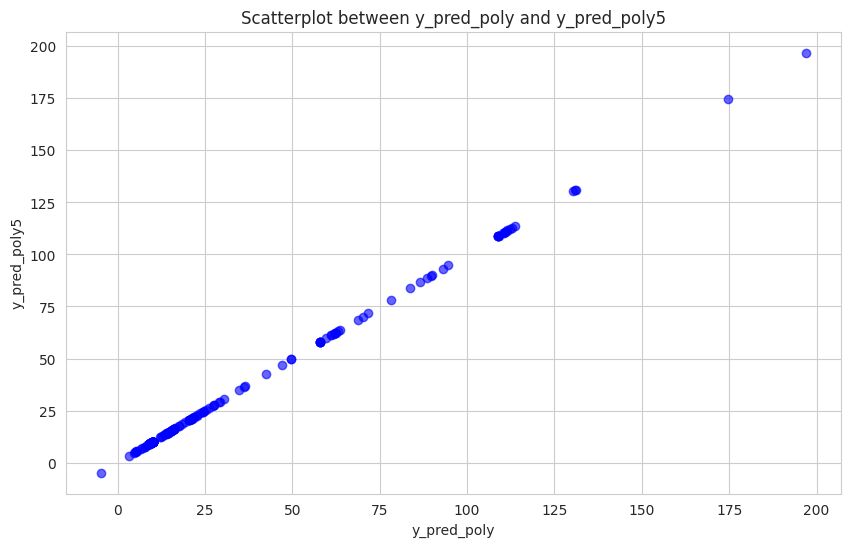

In [250]:
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_poly, y_pred_poly5, alpha=0.6, color='blue')
plt.xlabel('y_pred_poly')
plt.ylabel('y_pred_poly5')
plt.title('Scatterplot between y_pred_poly and y_pred_poly5')
plt.grid(True)
plt.show()

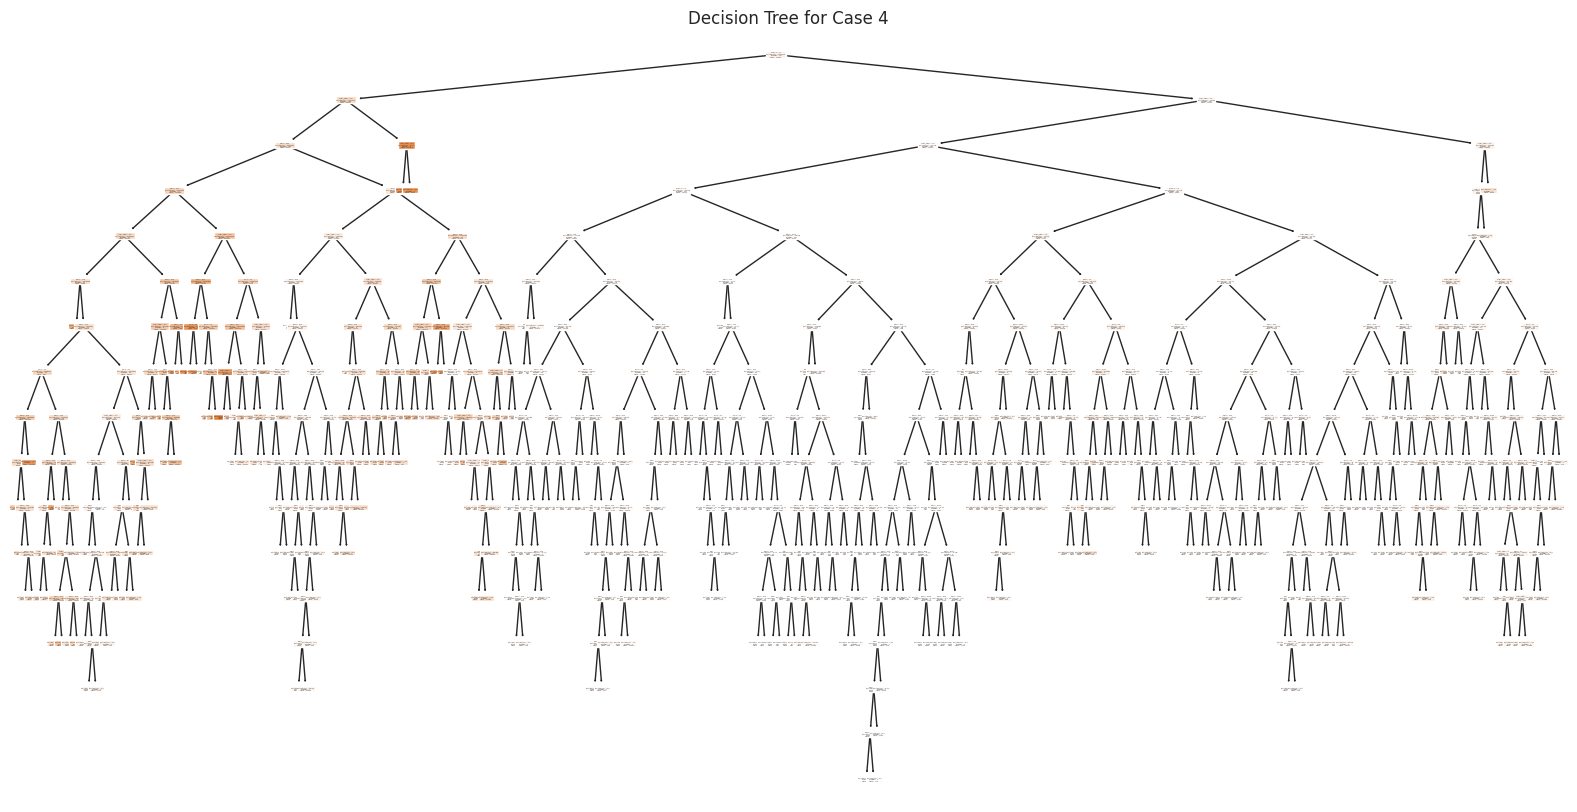

In [251]:
plt.figure(figsize=(20, 10))
plot_tree(tree_model, feature_names=X_train.columns, class_names=['Died', 'Survived'], filled=True)
plt.title('Decision Tree for Case 4')
plt.show()

# Reflection Questions (Section 3)
 - Why might these features affect a passenger’s fare:  Age might affect fare as children often receive a discount.  Especially if they are rooming with their parents/family.  Family size would as well for the same reason.  Similarly, passenger class likely also has as effect on fare.  First class certainly was more expensive.  In addition, the embarkation city may also have a role as well.  
 - List all available features: ['survived', 'pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked', 'class', 'who', 'adult_male', 'deck', 'embark_town', 'alive', 'alone', 'family_size']
 - Which other features could improve predictions and why: Deck might; however, it is likely related to passenger class.  In addition, there are a number of missing values too.  Probably not as useful.
 - How many variables are in your Case 4:  It is actually my case 6.  There are four variables.
 - Which variable(s) did you choose for Case 4 and why do you feel those could make good inputs:  age, pclass, sex, and family size.  I also experimented with embarked; but eventually omitted it.


# Reflection Questions (Secion 4)
## Compare the train vs test results for each.

 - Did Case 1 overfit or underfit? Explain: The feature used in my case 1 was alone.  This case underfitted with a training r2 of 0.06 and a test r2 of 0.12.
 - Did Case 2 overfit or underfit? Explain: The feature used in my case 2 was age.  This case underfitted with a training r2 of 0.012 and a test r2 of 0.034.
 - Did Case 3 overfit or underfit? Explain:  The feature used in my case 3 was family size.  This case underfitted with a training r2 of 0.045 and a test r2 of 0.062.
 - Did Case 4 overfit or underfit? Explain: The features used in my case 4 were age + family size.  This case underfitted with a training r2 of 0.074 and a test r2 of 0.13.
 - Did Case 5 overfit or underfit? Explain: The features used in my class 5 were pclass and embarked.  This case underfitted with a training r2 of 0.32 and a test r2 of 0.32.  I am calling this underfitting as both R2 values are still low.  However, they are comparable to one another.
 - Did Case 6 overfit or underfit? Explain: The features used in my case 6 were age, pclass, sex, and family size.  This case underfitted with a training r2 of 0.37 and a test r2 of 0.40.  I am calling this underfitting as both R2 values are still low.  

## Adding Age

 - Did adding age improve the model: Going from age alone to age and family size did improve the model. The training r2 increased from 0,045 to 0.074 and the test r2 increased from 0.062 to 0.13.  While this is an improvement, it is still low.  This means that the model is not doing a very good job of predicting the target variable.
 - Propose a possible explanation (consider how age might affect ticket price, and whether the data supports that): Looking at the plot of age vs fare, there seems to be very little correlation between the two.  One possible pattern that might be there is that below the age of ten, there are no passengers with a fare above 40 or so.  Could there heve been a discount only for passengers under the age of 10?

## Worst

 - Which case performed the worst: Age alone performed the worst.
 - How do you know: It had the lowest R2 values for both the training and test sets. 
 - Do you think adding more training data would improve it (and why/why not): No I do not.  I think that there are other variables that make more sense such as passenger class.

## Best

 - Which case performed the best: Case 6
 - How do you know: It had the highest R2 values for both the training and test sets.
 - Do you think adding more training data would improve it (and why/why not): 